The aim of this notebook is to develop and train a Long Short-Term Memory (LSTM) network to classify questions in the Stanford Question Answering Dataset (SQuAD) 2.0 as answerable or unanswerable. This classification is based on both the question and the context given.

SQuAD 2.0 combines the 100,000 questions in SQuAD1.1 with over 50,000 new, unanswerable questions. The challenge with SQuAD 2.0 is not only to answer the answerable questions correctly, but also to determine when a question is unanswerable, given a specific paragraph from a set of Wikipedia articles.

LSTMs are a type of recurrent neural network (RNN) that can learn and remember over long sequences of input data. They are particularly effective for natural language processing tasks because they can understand the context of words and the structure of sentences, thanks to their internal memory state. LSTMs have shown to be very effective in tasks like text generation, machine translation, and also question answering.

In this notebook, we will go through the following steps:

- Data Preprocessing: We will load the SQuAD 2.0 dataset, preprocess the data, and prepare it for the training phase. The preprocessing steps include text cleaning, tokenization, and data transformation to feed into the LSTM model.

- Model Building: We will build an LSTM-based classifier using the Keras library. The model architecture will be designed to process the input sequences and generate a binary classification output.

- Model Training: After defining our model, we will train it using the processed SQuAD 2.0 dataset.

- Model Evaluation: Finally, we will evaluate our model's performance on the test set and interpret the results.

This project involves deep learning, natural language processing, and the Python programming language, along with libraries like TensorFlow, Keras, and NLTK.

# Sequence Classification and the Use of LSTMs

Sequence classification is a predictive modeling problem where you have some sequence of inputs over space or time and the task is to predict a category for the sequence. In the context of natural language processing, a sequence could be a sentence, a paragraph, or even an entire document, and the categories could be different types of sentiment (in sentiment analysis), different topics (in topic modeling), or in our case, whether a question is answerable or unanswerable given a context.

This problem is difficult because the sequences can vary in length, comprise a very large vocabulary of input symbols, and may require the model to learn the long-term context or dependencies between symbols in the input sequence.

In [9]:
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence
import json
import requests
import pandas as pd
import numpy as np

# fix random seed for reproducibility
tf.random.set_seed(7)

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Loading and Preprocessing the SQuAD 2.0 Dataset

The first step in our notebook involves loading the Stanford Question Answering Dataset (SQuAD) 2.0 and extracting the relevant information for our task. The SQuAD 2.0 dataset is publicly available and can be downloaded directly from the web. We use Python's requests library to retrieve the JSON file containing the dataset.

The dataset is organized into articles, each containing several paragraphs. Each paragraph has a 'context' field, which is a passage from a Wikipedia article, and a 'qas' field, which is a list of questions and answers about the passage. Some of these questions are unanswerable given the context, indicated by the 'is_impossible' field.

Our task is to classify whether a question is answerable or unanswerable given the context, so we need to extract the context, the question, and the 'is_impossible' field for each question in the dataset. We represent each question-context pair as a single text sequence, with the question concatenated to the context, which will serve as the input to our model. The label for each sequence is a binary value, where 1 represents an answerable question and 0 represents an unanswerable question.

After processing the dataset, we end up with two lists: texts and labels. The texts list contains the concatenated question-context pairs, and the labels list contains the corresponding labels.

By structuring the data in this way, we are preparing it to be fed into our LSTM model for sequence classification. In the next steps, we will further preprocess the text data, transform it into a format suitable for the LSTM, and split it into training and validation sets.

In [10]:
# Load SQuAD 2.0 dataset
url = 'https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json'
r = requests.get(url)
squad_dataset = r.json()

texts = []
labels = []
# Extract contexts, questions, and labels (answerable or unanswerable)
for article in squad_dataset['data']:
    for paragraph in article['paragraphs']:
        context = paragraph['context']
        for qa in paragraph['qas']:
            question = qa['question']
            if qa['is_impossible']:
                label = 0
            else:
                label = 1
            # Concatenate context and question
            input_text = question  + ' '  + context 
            
            texts.append(input_text)
            labels.append(label)


# Splitting the Data into Training, Validation and Test Sets

Once we have preprocessed our dataset and structured it into input sequences (`texts`) and corresponding labels (`labels`), the next step is to split the data into training and validation sets. This is a crucial step in training any machine learning or deep learning model.

In this step, we are using the `train_test_split` function from the Scikit-learn library. This function shuffles the dataset and then splits it into training and validation sets. We have set the `test_size` parameter to 0.2, meaning that 80% of the data will be used for training, and the remaining 20% will be used for validation.

The training set is used to train the model, while the validation set is used to evaluate the model's performance on unseen data during the training process. This helps us monitor the model for overfitting and adjust the model's hyperparameters as needed to improve its performance.

The output of this step is four arrays: `train_x` and `train_y` contain the input sequences and labels for the training set, and `valid_x` and `valid_y` contain the input sequences and labels for the validation set. These will be used in the subsequent steps to train and validate our LSTM model.

In [11]:
from sklearn.model_selection import train_test_split
train_x, valid_x, train_y, valid_y = train_test_split(texts, labels, test_size=0.2)

In [12]:
url = 'https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json'
r = requests.get(url)
squad_dataset = r.json()

texts = []
labels = []
# Extract contexts, questions, and labels (answerable or unanswerable)
for article in squad_dataset['data']:
    for paragraph in article['paragraphs']:
        context = paragraph['context']
        for qa in paragraph['qas']:
            question = qa['question']
            if qa['is_impossible']:
                label = 0
            else:
                label = 1
            # Concatenate context and question
            input_text = question  + ' '  + context 
            
            texts.append(input_text)
            labels.append(label)

test_x = texts
test_y = labels

# Preparing the TensorFlow Data Pipelines

The next step is to create efficient data pipelines using TensorFlow's `tf.data` API. This API allows us to create a high-performance, complex input pipeline from our dataset, which is particularly useful when working with large datasets that don't fit into memory.

We create separate data pipelines for the training and validation data: `train_dataset` and `valid_dataset`.

For the `train_dataset`, we first use the `shuffle` method to shuffle the data in the buffer. Shuffling the training data serves to ensure that the model receives data in a random order, which contributes to a more robust learning process and helps prevent the model from learning unwanted patterns from the order of the samples.

The `buffer_size` parameter to the `shuffle` method determines the number of samples to load into the buffer from which the shuffle operation will draw. A larger buffer size provides better shuffling but uses more memory.

Next, we use the `batch` method to divide our data into batches of a specific size. Here, we use a batch size of 64. Batching allows the model to train on multiple samples at once, which can speed up the training process and help the model generalize better.

Finally, the `prefetch` method is used to prepare the next batch of data while the current batch is being processed. This method helps reduce the time waiting for data to be loaded, thereby improving the performance of the training process. We use `tf.data.AUTOTUNE` to automatically select the number of batches to prefetch based on the available resources.

We apply similar transformations to the `valid_dataset`, but without the shuffle operation, as the order of samples in the validation data does not affect the evaluation of the model.

By creating these data pipelines, we ensure that our training process is efficient and that the data is properly prepared for training our LSTM model.

In [13]:
import tensorflow as tf
train_tf = tf.data.Dataset.from_tensor_slices((train_x, train_y))
valid_tf = tf.data.Dataset.from_tensor_slices((valid_x, valid_y))

In [14]:
train_dataset = train_tf.shuffle(buffer_size=10000).batch(batch_size=64).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_tf.batch(batch_size=64).prefetch(tf.data.AUTOTUNE)

Let's have a look at the first batch in the training data. It consists of:
- an array of strings (Q&A)
- an array of binary values (class labels)

In [15]:
for batch in train_dataset.take(1):
  print(batch)

(<tf.Tensor: shape=(64,), dtype=string, numpy=
array([b"Where are RIBA's Study Rooms not located? The library is based at two public sites: the Reading Room at the RIBA's headquarters, 66 Portland Place, London; and the RIBA Architecture Study Rooms in the Henry Cole Wing of the V&A. The Reading Room, designed by the building's architect George Grey Wornum and his wife Miriam, retains its original 1934 Art Deco interior with open bookshelves, original furniture and double-height central space. The study rooms, opened in 2004, were designed by Wright & Wright. The library is funded entirely by the RIBA but it is open to the public without charge. It operates a free education programme aimed at students, education groups and families, and an information service for RIBA members and the public through the RIBA Information Centre.",
       b'When did the UK send troops to the Philippines to battle terrorists? In January 2002, the U.S. sent more than 1,200 troops (later raised to 2,000) to 

# Text Vectorization
The next step in our pipeline is text vectorization, which is the process of converting text data into a numerical representation that can be understood by our LSTM model. The TextVectorization layer in TensorFlow's Keras API provides a way to perform this transformation.

In this step, we initialize a TextVectorization layer with a specified maximum number of tokens (max_tokens). This parameter defines the size of the vocabulary that the layer will learn from the text data. A larger max_tokens value allows the vectorizer to learn a more complex vocabulary, but it also requires more memory and may lead to longer training times.

Next, we create a dataset (train_text) that includes only the input sequences (text data) from the training set. We use the map method to extract the text data from the train_dataset.

Then, we call the adapt method on our vectorizer and pass in the train_text dataset. The adapt method sets the internal state of the vectorizer so that it learns the vocabulary of the text data. This includes tokenizing the text into words, creating a vocabulary of these tokens, and saving a mapping from these tokens to numerical indices. Once the vectorizer has been adapted to the training text data, it can be used to transform any text into a numerical representation that our LSTM model can understand.

It's important to note that we only adapt the vectorizer on the training data to avoid data leakage, which occurs when information from the validation or test data is used to influence the training process. By only using the training data to learn the vocabulary, we ensure that the model's performance is evaluated on truly unseen data.

In [16]:
from tensorflow.keras.layers import TextVectorization
vectorizer = TextVectorization(max_tokens=5000)
train_text = train_dataset.map(lambda text, label: text)
vectorizer.adapt(train_text)

Let's print out the first tokens form the vocabulary:

In [17]:
vocab = vectorizer.get_vocabulary()
vocab[:100]

['',
 '[UNK]',
 'the',
 'of',
 'and',
 'in',
 'to',
 'a',
 'is',
 'as',
 'was',
 'for',
 'by',
 'that',
 'with',
 'on',
 'from',
 'are',
 'what',
 'which',
 'were',
 'or',
 'it',
 'at',
 'an',
 'be',
 'this',
 'have',
 'has',
 'not',
 'his',
 'its',
 'also',
 'their',
 'who',
 'other',
 'had',
 'first',
 'but',
 'one',
 'such',
 'new',
 'he',
 'many',
 'they',
 'did',
 'most',
 'when',
 'been',
 'more',
 'some',
 'after',
 'during',
 'into',
 'all',
 'city',
 'used',
 'than',
 'states',
 'can',
 'two',
 'between',
 'these',
 'there',
 'time',
 'may',
 'only',
 'united',
 'state',
 'world',
 'over',
 'century',
 'would',
 'war',
 'where',
 'while',
 'how',
 'known',
 'use',
 'about',
 'year',
 'years',
 'people',
 'us',
 'however',
 'under',
 'including',
 'system',
 'both',
 'government',
 'early',
 'made',
 'through',
 'no',
 'since',
 'called',
 'became',
 'part',
 'her',
 'later']

In this cell, we're testing the text vectorization process that we set up in the previous step. We're taking the first question-context pair from the training set (train_x[0]), and passing it through the vectorizer to transform it into a numerical representation.

The vectorizer transforms the input text into a sequence of integers, where each integer corresponds to a token (word or character) in the learned vocabulary. We use the .numpy() method to convert the output of the vectorizer into a numpy array, and then select the first (and only) element of the array, which is the sequence of encoded tokens.

We print out the original text and the encoded sequence to observe the transformation.

Finally, we recover the original text from the encoded sequence to verify the accuracy of the vectorization process. To do this, we map each encoded token back to its corresponding word in the learned vocabulary. We use a Python list comprehension to apply this mapping to each token in the encoded sequence, and then join the resulting words into a single string.

This step is important for verifying that our text vectorization process is working as expected. It's crucial that the vectorizer accurately encodes and decodes the text data, as any errors in this process could significantly impact the performance of our LSTM model.

In [18]:
text = train_x[0]
encoding = vectorizer([text]).numpy()[0]
print('Q&A:     ', text)
print('Encoded:   ', encoding) 
print('Recovered: ',' '.join([vocab[i] for i in encoding]))

Q&A:      What side of the island is the beach of St. Jean on? There are as many as 22 public beaches (most beaches on St Barthélémy are known as "Anse de..." etc. ) of which 15 are considered suitable for swimming. They are categorized and divided into two groups, the leeward side (calm waters protected by the island itself) and windward side (some of which are protected by hills and reefs). The windward beaches are popular for windsurfing. The beach of St Jean is suitable for water sports and facilities have been created for that purpose. The long beach at Lorient has shade and is a quiet beach as compared to St. Jean.
Encoded:    [  18  579    3    2  243    8    2 3523    3  374 4830   15   63   17
    9   43    9 1350  137    1   46    1   15  374    1   17   77    9
    1  239 1928    3   19  507   17  192 3847   11    1   44   17    1
    4  904   53   60  197    2    1  579    1 4348 2244   12    2  243
  424    4    1  579   50    3   19   17 2244   12 2917    4    1    2
    

Note that the vectorizer is not turning the text into a single vector, but is simply replacing the vocabulary words by their indices. If a word is not present in the dictionary it is replaced by the unknown token.

# Constructing the LSTM Model

Now we're ready to construct our LSTM model for sequence classification. We're using TensorFlow's Keras API to define our model as a sequence of layers. The model consists of the following layers:

1. **TextVectorization layer (`vectorizer`)**: This is the text vectorization layer we trained earlier. It will transform the input text into a sequence of integer tokens.

2. **Embedding layer**: This layer transforms the integer tokens into dense vectors of fixed size. Each token (i.e., each unique word in our vocabulary) gets mapped to a vector in the embedding space. The `input_dim` parameter is the size of the vocabulary, and the `output_dim` parameter is the size of the embedding vectors. The `mask_zero` parameter is set to `True`, which means that padding tokens (represented by 0) will be ignored by subsequent layers.

3. **Bidirectional LSTM layer**: This layer uses two LSTM layers that process the input sequence in both directions (forward and backward). This allows the model to capture both past and future context when processing a token. The size of the LSTM layers is set to 128.

4. **Dropout layer**: This layer randomly sets a fraction of the input units to 0 at each update during training, which helps prevent overfitting. The fraction rate is set to 0.2.

5. **Dense layers**: These are fully-connected layers. The first two dense layers have 64 units and use the ReLU (Rectified Linear Unit) activation function. The final dense layer has 1 unit, which will output the prediction of the model for the input sequence.

After defining the architecture of the model, we compile it with a loss function, a metric, and an optimizer. 

- We're using the binary cross-entropy loss function, which is suitable for binary classification problems. The `from_logits` parameter is set to `True` because our final layer does not have an activation function, so the model will output logits (values before applying the activation function).

- The metric we're tracking is accuracy, which measures the proportion of correct predictions.

- The optimizer we're using is Adam, which is a popular choice for deep learning models. We're setting the learning rate to 1e-5.

The resulting model is ready to be trained on our question-context pairs to classify them as answerable or unanswerable.

In order to evaluate the performance of our models we will use the following metrics:
*   $Accuracy = \frac{TP+TN}{TP+TN+FP+FN}$
*   $Precision = \frac{TP}{TP+FP}$
*   $Recall = \frac{TP}{TP+FN}$
*   $F1 = \frac{2*Precision*Recall}{Precision+Recall} = \frac{2*TP}{2*TP+FP+FN}$

where 
*   `TP` (true prositives) is the number of correctly predicted answerable questions.
*   `TN` (true negatives) is the number of correctly predicted unanswerable questions.
*   `FP` (false prositives) is the number of wrongly predicted answerable questions.
*   `FN` (false negatives) is the number of wrongly predicted unanswerable questions.


In [23]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [24]:
model = tf.keras.Sequential([
    vectorizer,                       
    tf.keras.layers.Embedding(input_dim=len(vectorizer.get_vocabulary()), output_dim=64, mask_zero=True), 
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dropout(.2, input_shape=(64,)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy', precision_m, recall_m, f1_m], optimizer=tf.keras.optimizers.Adam(1e-5))

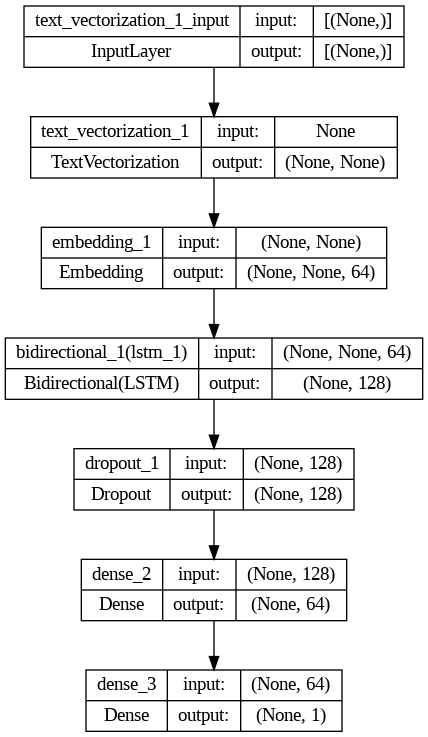

In [25]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True)

In [26]:
tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.1,
    patience=3,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=2
)

# Training the LSTM Model
With our model compiled and our training and validation data prepared, we can now train our model using the fit method.

We pass the train_dataset as the training data and specify the number of epochs for which we want to train our model. An epoch is one pass through the entire training dataset. We have set epochs to 20, meaning that the model will iterate over the entire training dataset 20 times.

We also pass the valid_dataset as the validation data. The model will evaluate its performance on the validation data after each epoch, which allows us to monitor the model's learning process and adjust hyperparameters or stop training early if necessary to prevent overfitting.

We set validation_steps to 20, which means that the model will use 20 batches of data from the valid_dataset for each validation check. This parameter can be useful when the validation dataset is large and we want to speed up the validation process.

The fit method returns a History object that contains a record of the loss values and metric values during training. We store this object in the history variable, so we can use it later to plot the training and validation loss and accuracy over time.

In [27]:
history = model.fit(train_dataset, epochs=20, validation_data=valid_dataset, validation_steps=20)

Epoch 1/20
1629/1629 [==============================] - 130s 71ms/step - loss: 0.6531 - accuracy: 0.5270 - precision_m: 0.4297 - recall_m: 0.5735 - f1_m: 0.4869 - val_loss: 0.6207 - val_accuracy: 0.6781 - val_precision_m: 0.6922 - val_recall_m: 0.9614 - val_f1_m: 0.8034
Epoch 2/20
1629/1629 [==============================] - 53s 33ms/step - loss: 0.6328 - accuracy: 0.6500 - precision_m: 0.6731 - recall_m: 0.9228 - f1_m: 0.7765 - val_loss: 0.6171 - val_accuracy: 0.6766 - val_precision_m: 0.6970 - val_recall_m: 0.9380 - val_f1_m: 0.7986
Epoch 3/20
1629/1629 [==============================] - 52s 32ms/step - loss: 0.6230 - accuracy: 0.6543 - precision_m: 0.6889 - recall_m: 0.8789 - f1_m: 0.7698 - val_loss: 0.6069 - val_accuracy: 0.6484 - val_precision_m: 0.7194 - val_recall_m: 0.8014 - val_f1_m: 0.7565
Epoch 4/20
1629/1629 [==============================] - 52s 32ms/step - loss: 0.6070 - accuracy: 0.6484 - precision_m: 0.7243 - recall_m: 0.7638 - f1_m: 0.7404 - val_loss: 0.5967 - val_accu

# Evaluating the Model
After training our LSTM model, we evaluate its performance on the validation dataset using the evaluate method. This method computes the loss and any metrics specified during model compilation for the input data.

In this step, we pass our validation input sequences (valid_x) and labels (valid_y) to the evaluate method. The method returns the metrics of the model on the validation data.

Finally, we print out all the defined metrics to observe how well our model performs on unseen data.

In [30]:
valid_loss, valid_acc, valid_precision, valid_recall, valid_f1 = model.evaluate(valid_x, valid_y)

print('Validation Loss: {}'.format(valid_loss))
print('Validation Accuracy: ',valid_acc)
print('Validation Precision: ',valid_precision)
print('Validation Recall: ',valid_recall)
print('Validation F1: ',valid_f1)

815/815 [==============================] - 10s 12ms/step - loss: 0.5263 - accuracy: 0.6597 - precision_m: 0.8662 - recall_m: 0.5787 - f1_m: 0.6874
Validation Loss: 0.5262996554374695
Validation Accuracy:  0.6597222089767456
Validation Precision:  0.8661539554595947
Validation Recall:  0.5786503553390503
Validation F1:  0.6873588562011719


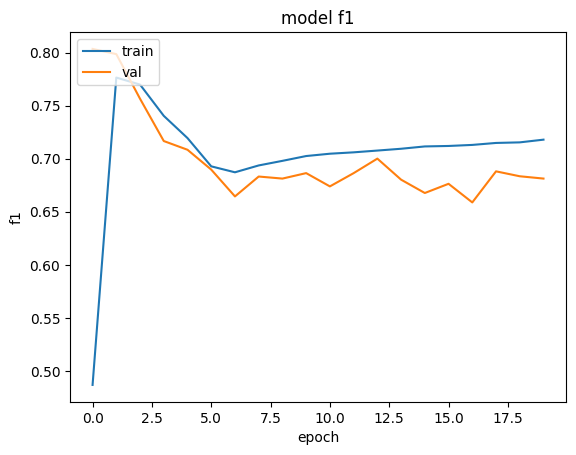

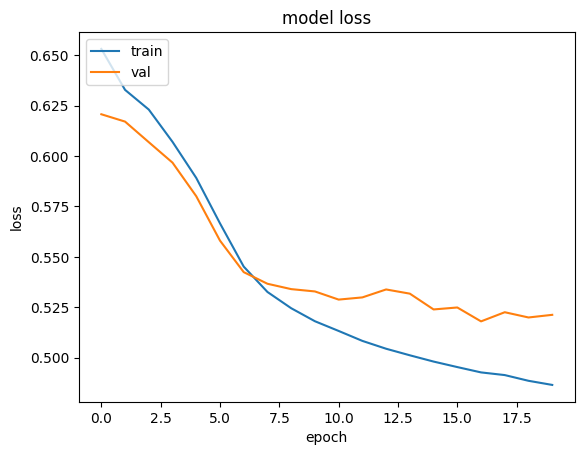

In [37]:
from matplotlib import pyplot as plt

plt.plot(history.history['f1_m'])
plt.plot(history.history['val_f1_m'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()